In [1]:
# tested with pytorch 1.2.0 

# import matplotlib
# matplotlib.use('Qt4Agg') # if problem with PyQt5
import matplotlib.pyplot as plt
my_seed = 0
import numpy as np
np.random.seed(my_seed)
import torch
torch.manual_seed(my_seed)
import torch.nn as nn
from utils import to_img, plot_reconstructions_VAE, display_digits
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


# Variational autoencoder

## Generative model

Let $\mathbf{x} \in \mathbb{R}^D$ and $\mathbf{z} \in \mathbb{R}^K$ be two random vectors (with $K \ll D$). 

**Generative model**: We consider the following generative model:


$$p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$$

$$p(\mathbf{x} | \mathbf{z} ; \theta ) = \mathcal{N}\left( \boldsymbol{\mu}_\theta(\mathbf{z}), \mathbf{I} \right)$$

The decoder outputs $\boldsymbol{\mu}_\theta(\mathbf{z})$. In theory, the mean of a Gaussian distribution lies in $]- \infty, +\infty[$. However, we know that our data (MNIST images) lie in $[0, 1]^D$, so we expect the mean of $p(\mathbf{x} | \mathbf{z} ; \theta )$ to be in this interval too. This can be enforced by using a sigmoid activation function on the output layer.

In [3]:
class VAE(nn.Module):
    
    def __init__(self, input_dim, encoding_dim):
        
        super(VAE, self).__init__()
        
        self.decoder_fc1 = nn.Linear(encoding_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 512)
        self.decoder_output_mean = nn.Linear(512, input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def decode(self, z):
        """
        From a latent vector, this function computes and returns 
        the mean of p(x|z).
        """
    
        z = self.relu(self.decoder_fc1(z))
        z = self.relu(self.decoder_fc2(z))
        z = self.sigmoid(self.decoder_output_mean(z)) 
        
        return z
        
    def forward(self, x):
        
        pass

We instantiate the model:

In [4]:
encoding_dim = 16
input_dim = 784 # images of 28 x 28 pixels

model = VAE(input_dim, encoding_dim)

model = model.to(device)

print(model)

VAE(
  (decoder_fc1): Linear(in_features=16, out_features=128, bias=True)
  (decoder_fc2): Linear(in_features=128, out_features=512, bias=True)
  (decoder_output_mean): Linear(in_features=512, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


We sample from the model.

In [5]:
def sample_VAE(model, encoding_dim):
    with torch.no_grad():
        # sample a Gaussian random vector with zero mean and identity covariance matrix
        z = torch.randn(1,encoding_dim).to(device)
        # pass it through the decoder
        x = model.decode(z).reshape(28,28).cpu()
    return x

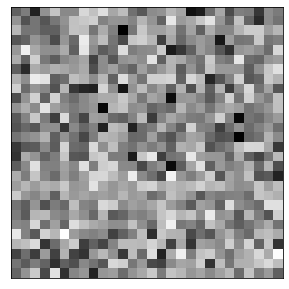

In [6]:
x = sample_VAE(model, encoding_dim)

display_digits(x[np.newaxis, np.newaxis, :], n_i=1, n_j=1, figsize=(5, 5))

## Inference model


**Inference model**: We consider the following inference model:

$$q(\mathbf{z} | \mathbf{x}; \phi) = \mathcal{N}\left( \boldsymbol{\mu}_\phi(\mathbf{x}), \text{diag}\left\{ \mathbf{v}_\phi(\mathbf{x}) \right\} \right)$$


The encoder outputs $\boldsymbol{\mu}_\phi(\mathbf{x})$ and $\mathbf{v}_\phi(\mathbf{x})$. A variance has to be positive, so a common practice consists in considering that the network ouputs the logarithm of the variance. You have to properly choose the activation function of the output layer of the encoder based on this information.

In [7]:
class VAE(nn.Module):
    
    def __init__(self, input_dim, encoding_dim):
        
        super(VAE, self).__init__()
        
        self.encoder_fc1 = nn.Linear(input_dim, 512)
        self.encoder_fc2 = nn.Linear(512, 128)
        self.encoder_output_mean = nn.Linear(128, encoding_dim)
        self.encoder_output_log_var = nn.Linear(128, encoding_dim)
        
        self.decoder_fc1 = nn.Linear(encoding_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 512)
        self.decoder_output_mean = nn.Linear(512, input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        """
        From an input vector (MNIST image), this function computes 
        and returns the mean and log-variance of q(z|x).
        """
        
        x = self.relu(self.encoder_fc1(x))
        x = self.relu(self.encoder_fc2(x))
        
        return self.encoder_output_mean(x), self.encoder_output_log_var(x)
        
    def decode(self, z):
        """
        From a latent vector, this function computes and returns 
        the mean of p(x|z).
        """
        
        z = self.relu(self.decoder_fc1(z))
        z = self.relu(self.decoder_fc2(z))
        z = self.sigmoid(self.decoder_output_mean(z)) 
        
        return z
    
    def forward(self, x):
        
        pass

## Almost complete VAE model

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(VAE, self).__init__()
        
        self.encoder_fc1 = nn.Linear(input_dim, 512)
        self.encoder_fc2 = nn.Linear(512, 128)
        self.encoder_output_mean = nn.Linear(128, encoding_dim)
        self.encoder_output_log_var = nn.Linear(128, encoding_dim)
        
        self.decoder_fc1 = nn.Linear(encoding_dim, 128)
        self.decoder_fc2 = nn.Linear(128, 512)
        self.decoder_output_mean = nn.Linear(512, input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        """
        From an input vector (MNIST image), this function computes 
        and returns the mean and log-variance of q(z|x).
        """
        x = self.relu(self.encoder_fc1(x))
        x = self.relu(self.encoder_fc2(x))
        return self.encoder_output_mean(x), self.encoder_output_log_var(x)
        
    def decode(self, z):
        """
        From a latent vector, this function computes and returns 
        the mean of p(x|z).
        """
        z = self.relu(self.decoder_fc1(z))
        z = self.relu(self.decoder_fc2(z))
        z = self.sigmoid(self.decoder_output_mean(z)) 
        return z
    
    def reparameterize(self, mu, log_var):
        """
        From the mean and log-variance of q(z|x), this function returns a 
        latent vector drawn from q(z|x) using the reparametrization trick.
        """
        ######### TO COMPLETE #########

        ###############################
    
    def forward(self, x):
        
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        
        return x_hat, mu, log_var

In the forward, between encoding and decoding, we have to sample from the inference model using the reparametrization trick. 

Complete the ```reparameterize``` function (3 lines of code). 

You can use the following PyTorch functions: [torch.randn_like](https://pytorch.org/docs/stable/torch.html#torch.randn_like) and [torch.exp](https://pytorch.org/docs/stable/torch.html#torch.exp).